# Load packages

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [37]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [38]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [39]:
import time
import gc

In [40]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [41]:
import os
import torch
import torchvision
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
from multiprocessing import Process
from torch.utils.data import TensorDataset, DataLoader
import math

In [42]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

# Specify parameters

In [43]:
file_name = "../OD_pair/Abilene-OD_pair.csv"  # the input filename
nodes = 12  # nodes in the traffic matrix

history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'ConvLSTM'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [44]:
nodes * nodes

144

In [45]:
y_true_fn

'ConvLSTM_true_TM-minmax-10-1.pkl'

In [46]:
y_pred_fn

'ConvLSTM_pred_TM-minmax-10-1.pkl'

# Load data

In [47]:
df = pd.read_csv(file_name)

In [48]:
df.head()

,time,OD_1-1,OD_1-2,OD_1-3,OD_1-4,OD_1-5,OD_1-6,OD_1-7,OD_1-8,OD_1-9,...,OD_12-3,OD_12-4,OD_12-5,OD_12-6,OD_12-7,OD_12-8,OD_12-9,OD_12-10,OD_12-11,OD_12-12
0,2004-03-01-00-00,26.666667,522.208000,1641.338667,335.728000,413.032000,489.874667,365.077333,817.869333,452.061333,...,66541.197333,36063.421333,15439.312000,62781.813333,32642.733333,91675.626667,133661.405333,1980.576000,29760.202667,187653.482667
1,2004-03-01-00-05,26.666667,465.701333,868.098667,148.346667,398.701333,1821.269333,402.144000,1090.848000,585.202667,...,62246.088000,34109.810667,15664.965333,56823.610667,24912.210667,100567.461333,137277.728000,4411.589333,30667.266667,190925.981333
2,2004-03-01-00-10,53.333333,375.261333,1082.378667,276.136000,453.426667,1703.384000,407.152000,403.664000,853.005333,...,70181.930667,29905.896000,19918.581333,58658.568000,19036.714667,92415.480000,153845.554667,5300.653333,39990.880000,218742.773333
3,2004-03-01-00-15,67.274667,498.360000,1332.205333,121.269333,425.168000,794.472000,506.746667,142.328000,818.728000,...,74490.416000,44822.789333,16250.042667,50589.922667,18758.725333,97793.093333,159339.533333,4490.272000,38331.688000,265665.077333
4,2004-03-01-00-20,26.666667,723.962667,1428.480000,165.938667,459.965333,403.757333,303.256000,257.877333,848.208000,...,69881.266667,44536.856000,18448.840000,51095.165333,18614.133333,93446.560000,151623.424000,3487.808000,43462.373333,210540.786667


Parse the time column:

In [49]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [50]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [51]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [52]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [53]:
df_ts.index[train_length:][0]

Timestamp('2004-07-12 14:25:00', freq='5T')

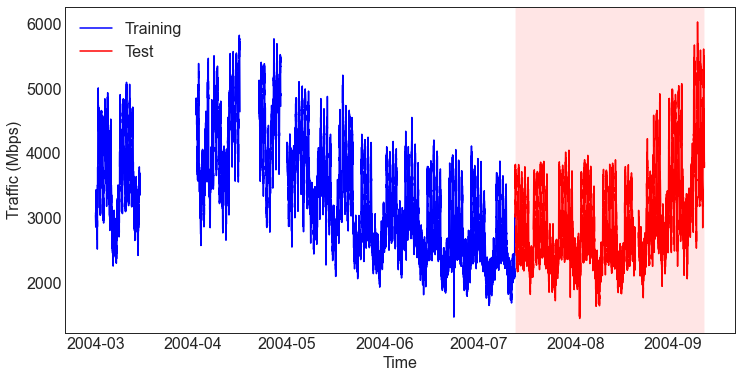

In [54]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [55]:
max_list = np.max(data[:train_length], axis=0)

In [56]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [57]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [58]:
print(np.max(data[:train_length].flatten()))

1.0


In [59]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [60]:
print(np.max(data.flatten()))

5.940447088662937


In [61]:
print(np.min(data.flatten()))

-0.0023245664896374284


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [62]:
x_data = []
y_data = []

In [63]:
length = data.shape[0]
print(length)

48096


In [64]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [65]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [66]:
x_data.shape

(48086, 10, 144)

In [67]:
y_data.shape

(48086, 1, 144)

Reshape x_data as required by ConvLSTM models.

**This format is required by ConvLSTM: [data size, input historical steps, channel, nodes, nodes].**

In [68]:
# x_data = np.swapaxes(x_data, 1, 2)
x_data = x_data.reshape(x_data.shape[0], x_data.shape[1], 1, nodes, nodes)
x_data.shape

(48086, 10, 1, 12, 12)

Reshape y_data too:

In [69]:
y_data.shape

(48086, 1, 144)

In [70]:
y_data = y_data.reshape(y_data.shape[0], y_data.shape[1], 1, nodes, nodes)
y_data.shape

(48086, 1, 1, 12, 12)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [71]:
test_length = test_length - horizon + 1

In [72]:
train_valid_length = x_data.shape[0] - test_length

In [73]:
train_valid_length

38467

We further split a valid data set for hyper parameter tuning:

In [74]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [75]:
train_length

30773

In [76]:
valid_length

7694

In [77]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [78]:
X_train.shape

(30773, 10, 1, 12, 12)

In [79]:
y_train.shape

(30773, 1, 1, 12, 12)

In [80]:
X_valid.shape

(7694, 10, 1, 12, 12)

In [81]:
y_valid.shape

(7694, 1, 1, 12, 12)

In [82]:
X_test.shape

(9619, 10, 1, 12, 12)

In [83]:
y_test.shape

(9619, 1, 1, 12, 12)

# Build Model

We aim to build a Seq2Seq model with ConvLSTM:

In [84]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [85]:
class EncoderDecoderConvLSTM(nn.Module):
    def __init__(self, nf, in_chan):
        super(EncoderDecoderConvLSTM, self).__init__()

        """ ARCHITECTURE 

        # Encoder (ConvLSTM)
        # Encoder Vector (final hidden state of encoder)
        # Decoder (ConvLSTM) - takes Encoder Vector as input
        # Decoder (3D CNN) - produces regression predictions for our model

        """
        self.encoder_1_convlstm = ConvLSTMCell(input_dim=in_chan,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.encoder_2_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_1_convlstm = ConvLSTMCell(input_dim=nf,  # nf + 1
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_2_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_CNN = nn.Conv3d(in_channels=nf,
                                     out_channels=1,
                                     kernel_size=(1, 3, 3),
                                     padding=(0, 1, 1))


    def autoencoder(self, x, seq_len, future_step, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4):

        outputs = []

        # encoder
        for t in range(seq_len):
            h_t, c_t = self.encoder_1_convlstm(input_tensor=x[:, t, :, :],
                                               cur_state=[h_t, c_t])  # we could concat to provide skip conn here
            h_t2, c_t2 = self.encoder_2_convlstm(input_tensor=h_t,
                                                 cur_state=[h_t2, c_t2])  # we could concat to provide skip conn here

        # encoder_vector
        encoder_vector = h_t2

        # decoder
        for t in range(future_step):
            h_t3, c_t3 = self.decoder_1_convlstm(input_tensor=encoder_vector,
                                                 cur_state=[h_t3, c_t3])  # we could concat to provide skip conn here
            h_t4, c_t4 = self.decoder_2_convlstm(input_tensor=h_t3,
                                                 cur_state=[h_t4, c_t4])  # we could concat to provide skip conn here
            encoder_vector = h_t4
            outputs += [h_t4]  # predictions

        outputs = torch.stack(outputs, 1)
        outputs = outputs.permute(0, 2, 1, 3, 4)
        outputs = self.decoder_CNN(outputs)
        outputs = torch.nn.Sigmoid()(outputs)

        return outputs

    def forward(self, x, future_seq=0, hidden_state=None):

        """
        Parameters
        ----------
        input_tensor:
            5-D Tensor of shape (b, t, c, h, w)        #   batch, time, channel, height, width
        """

        # find size of different input dimensions
        b, seq_len, _, h, w = x.size()

        # initialize hidden states
        h_t, c_t = self.encoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t2, c_t2 = self.encoder_2_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t3, c_t3 = self.decoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t4, c_t4 = self.decoder_2_convlstm.init_hidden(batch_size=b, image_size=(h, w))

        # autoencoder forward
        outputs = self.autoencoder(x, seq_len, future_seq, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4)

        return outputs

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [86]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [1e-2, 1e-3, 1e-4]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # model parameters
    "n_hidden_dim": hp.choice('n_hidden_dim', [16, 32, 64])
}

In [87]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x292926a1588>,
 'lr': <hyperopt.pyll.base.Apply at 0x292d8720f88>,
 'epochs': <hyperopt.pyll.base.Apply at 0x29291b6aa08>,
 'patience': <hyperopt.pyll.base.Apply at 0x292922abd08>,
 'n_hidden_dim': <hyperopt.pyll.base.Apply at 0x29291b082c8>}

In [88]:
# clear memory 
gc.collect()

5856

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [90]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        
        # Create model
        class TMLightning(pl.LightningModule):
        
            def __init__(self, hparams=None, model=None):
                super(TMLightning, self).__init__()
        
                # default config
                self.normalize = False
                self.model = model
        
                # Training config
                self.criterion = torch.nn.MSELoss()
                self.batch_size = params['batch_size']
                self.n_steps_past = history
                self.n_steps_ahead = horizon
        
            def forward(self, x):
                x = x.to(device)
        
                output = self.model(x, future_seq=self.n_steps_ahead)
        
                return output
        
            def training_step(self, batch, batch_idx):
                x, y = batch
                y_hat = self.forward(x)
        
                loss = self.criterion(y_hat, y)
        
                # save learning_rate
                lr_saved = self.trainer.optimizers[0].param_groups[-1]['lr']
                lr_saved = torch.scalar_tensor(lr_saved).cuda()
        
                tensorboard_logs = {'train_mse_loss': loss,
                                    'learning_rate': lr_saved}
        
                return {'loss': loss, 'log': tensorboard_logs}
            
            def validation_step(self, batch, batch_idx):
                x, y = batch
                y_hat = self.forward(x)
                loss = self.criterion(y_hat, y)
                self.log('val_loss', loss)
                return {'val_loss': loss, 'log': {'val_loss': loss}}
        
            def validation_epoch_end(self, outputs):
                val_loss_mean = sum([o['val_loss'] for o in outputs]) / len(outputs)
                # show val_acc in progress bar but only log val_loss
                results = {'progress_bar': {'val_loss': val_loss_mean.item()}, 'log': {'val_loss': val_loss_mean.item()},
                        'val_loss': val_loss_mean.item()}
                return results
        
            def test_step(self, batch, batch_idx):
                # OPTIONAL
                x, y = batch
                y_hat = self.forward(x)
                return {'test_loss': self.criterion(y_hat, y)}
        
            def test_end(self, outputs):
                # OPTIONAL
                avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
                tensorboard_logs = {'test_loss': avg_loss}
                return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
        
            def configure_optimizers(self):
                return torch.optim.Adam(self.parameters(), lr=params['lr'], betas=(0.9, 0.98))
        
            def train_dataloader(self):
                tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
                tensor_y_train = torch.Tensor(y_train)
        
                train_dataset = TensorDataset(tensor_x_train, tensor_y_train)  # create datset
                train_loader = DataLoader(train_dataset,
                    batch_size=self.batch_size,
                    shuffle=True)  # create dataloader
        
                return train_loader
            
            def val_dataloader(self):
                tensor_x_valid = torch.Tensor(X_valid) # transform to torch tensor
                tensor_y_valid = torch.Tensor(y_valid)
        
                valid_dataset = TensorDataset(tensor_x_valid, tensor_y_valid)  # create datset
                valid_loader = DataLoader(valid_dataset,
                    batch_size=self.batch_size,
                    shuffle=True)  # create dataloader
        
                return valid_loader
        
            def test_dataloader(self):
                tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
                tensor_y_test = torch.Tensor(y_test)
        
                test_dataset = TensorDataset(tensor_x_test, tensor_y_test)  # create datset
                test_loader = DataLoader(test_dataset,
                    batch_size=self.batch_size,
                    shuffle=False)  # create dataloader
        
                return test_loader
        
        conv_lstm_model = EncoderDecoderConvLSTM(nf=params['n_hidden_dim'], in_chan=1)
        model = TMLightning(model=conv_lstm_model)
        model.to(device)
        
        # Training the model
        early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=params['patience'], verbose=False, mode='min')
        trainer = Trainer(max_epochs=params['epochs'], gpus=1, callbacks=[early_stop_callback])
        trainer.fit(model)
        
        # get val_loss
        val_loss = float(trainer.logged_metrics['val_loss'].cpu().numpy())
        
        # clear memory
        del conv_lstm_model
        del model
        del trainer
        gc.collect()

        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except Exception as e:
        print(e.message)
        return {'loss': None, 'status': STATUS_FAIL}

In [91]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 10}                                    
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'n_hidden_dim': 32, 'patience': 10}                                       
  1%|▍                                         | 1/100 [09:36<15:50:26, 576.02s/trial, best loss: 0.001510236645117402]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 16, 'patience': 10}                                      
  2%|▊                                         | 2/100 [23:20<17:42:41, 650.63s/trial, best loss: 0.001314708380959928]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 5}                                     
  3%|█▏                                       | 3/100 [40:32<20:36:31, 764.86s/trial, best loss: 0.0011901028919965029]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 10}                                     
  4%|█▌                                    | 4/100 [1:16:07<31:21:22, 1175.85s/trial, best loss: 0.0011901028919965029]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                     
  5%|█▉                                     | 5/100 [1:20:56<24:00:44, 909.94s/trial, best loss: 0.0011901028919965029]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                      
  6%|██▎                                   | 6/100 [1:41:30<26:17:39, 1007.02s/trial, best loss: 0.0011901028919965029]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
  7%|██▋                                   | 7/100 [2:04:26<28:52:41, 1117.86s/trial, best loss: 0.0011901028919965029]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 10}                                    
  8%|███                                   | 8/100 [2:33:31<33:22:39, 1306.08s/trial, best loss: 0.0011861380189657211]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 5}                                      
  9%|███▍                                  | 9/100 [2:49:46<30:30:00, 1206.60s/trial, best loss: 0.0011647146893665195]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
 10%|███▋                                 | 10/100 [3:02:02<26:38:10, 1065.45s/trial, best loss: 0.0011647146893665195]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 10}                                       
 11%|████▏                                 | 11/100 [3:17:31<25:19:31, 1024.40s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 32, 'patience': 10}                                      
 12%|████▌                                 | 12/100 [3:37:31<26:19:53, 1077.20s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 10}                                     
 13%|████▉                                 | 13/100 [3:54:40<25:40:53, 1062.68s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 32, 'patience': 10}                                      
 14%|█████▎                                | 14/100 [4:29:25<32:43:00, 1369.54s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.0001, 'n_hidden_dim': 32, 'patience': 5}                                      
 15%|█████▋                                | 15/100 [4:56:07<33:58:41, 1439.08s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                     
 16%|██████                                | 16/100 [5:09:54<29:17:57, 1255.69s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 32, 'patience': 10}                                     
 17%|██████▍                               | 17/100 [6:02:55<42:15:47, 1833.10s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 5}                                      
 18%|██████▊                               | 18/100 [6:37:40<43:28:33, 1908.70s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 10}                                      
 19%|███████▏                              | 19/100 [6:42:27<31:59:53, 1422.15s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                      
 20%|███████▌                              | 20/100 [6:56:12<27:37:35, 1243.19s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                     
 21%|███████▉                              | 21/100 [7:06:07<23:00:39, 1048.60s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                      
 22%|████████▌                              | 22/100 [7:08:23<16:47:10, 774.75s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 10}                                     
 23%|████████▉                              | 23/100 [7:10:41<12:29:04, 583.70s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 10}                                     
 24%|█████████▎                             | 24/100 [7:24:55<14:02:12, 664.90s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                      
 25%|█████████▊                             | 25/100 [7:35:39<13:43:12, 658.56s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 10}                                     
 26%|██████████▏                            | 26/100 [7:38:12<10:25:04, 506.82s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                     
 27%|██████████▌                            | 27/100 [7:50:01<11:30:40, 567.68s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 10}                                     
 28%|██████████▉                            | 28/100 [8:04:30<13:09:26, 657.87s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 29%|███████████▎                           | 29/100 [8:15:08<12:51:42, 652.15s/trial, best loss: 0.001156764104962349]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 30%|███████████▋                           | 30/100 [8:31:26<14:34:42, 749.76s/trial, best loss: 0.001153930788859725]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 31%|████████████                           | 31/100 [8:49:36<16:19:46, 851.98s/trial, best loss: 0.001153698773123324]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                        
 32%|████████████▏                         | 32/100 [9:01:40<15:22:02, 813.57s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 33%|████████████▌                         | 33/100 [9:08:50<12:59:59, 698.50s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                        
 34%|████████████▉                         | 34/100 [9:25:09<14:20:44, 782.49s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 35%|█████████████▎                        | 35/100 [9:37:22<13:51:50, 767.85s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 36%|█████████████▋                        | 36/100 [9:51:47<14:10:00, 796.88s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 37%|█████████████▋                       | 37/100 [10:09:05<15:12:47, 869.33s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 38%|██████████████                       | 38/100 [10:28:11<16:23:52, 952.14s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                       
 39%|██████████████                      | 39/100 [10:49:29<17:47:25, 1049.93s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 40%|██████████████▍                     | 40/100 [11:04:51<16:51:37, 1011.62s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 41%|███████████████▏                     | 41/100 [11:19:12<15:50:24, 966.51s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                       
 42%|███████████████▌                     | 42/100 [11:36:46<15:59:31, 992.61s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 5}                                       
 43%|███████████████▍                    | 43/100 [11:57:20<16:51:41, 1064.93s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                     
 44%|████████████████▎                    | 44/100 [12:02:55<13:09:32, 845.94s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 45%|████████████████▏                   | 45/100 [13:49:27<38:20:45, 2509.92s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                       
 46%|████████████████▌                   | 46/100 [14:07:47<31:18:14, 2086.93s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 5}                                      
 47%|████████████████▉                   | 47/100 [14:15:26<23:32:08, 1598.66s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 48%|█████████████████▎                  | 48/100 [14:29:19<19:46:21, 1368.88s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 49%|█████████████████▋                  | 49/100 [14:35:42<15:12:01, 1072.97s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 5}                                      
 50%|██████████████████                  | 50/100 [14:54:03<15:01:16, 1081.52s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 10}                                      
 51%|██████████████████▎                 | 51/100 [15:07:45<13:39:31, 1003.51s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 52%|██████████████████▋                 | 52/100 [15:26:55<13:58:05, 1047.60s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 10}                                      
 53%|███████████████████                 | 53/100 [15:58:30<16:59:42, 1301.75s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                     
 54%|███████████████████▍                | 54/100 [16:05:29<13:14:56, 1036.89s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 55%|███████████████████▊                | 55/100 [16:55:40<20:21:49, 1629.09s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 16, 'patience': 10}                                      
 56%|████████████████████▏               | 56/100 [17:13:46<17:55:12, 1466.20s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 57%|████████████████████▌               | 57/100 [17:23:25<14:20:06, 1200.15s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                    
 58%|████████████████████▉               | 58/100 [17:43:24<13:59:52, 1199.81s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 10}                                     
 59%|█████████████████████▏              | 59/100 [18:39:17<21:01:16, 1845.76s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 60%|█████████████████████▌              | 60/100 [19:01:36<18:49:11, 1693.79s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                     
 61%|█████████████████████▉              | 61/100 [19:18:38<16:09:53, 1492.15s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 10}                                     
 62%|██████████████████████▎             | 62/100 [19:45:01<16:02:12, 1519.29s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 16, 'patience': 5}                                       
 63%|██████████████████████▋             | 63/100 [20:04:58<14:37:24, 1422.83s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 64%|███████████████████████             | 64/100 [20:11:14<11:05:07, 1108.53s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 65%|███████████████████████▍            | 65/100 [20:26:09<10:09:26, 1044.76s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 66%|███████████████████████▊            | 66/100 [20:47:11<10:28:48, 1109.67s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 67%|████████████████████████▊            | 67/100 [21:04:18<9:56:45, 1085.01s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 68%|████████████████████████▍           | 68/100 [21:25:26<10:07:52, 1139.77s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 69%|████████████████████████▊           | 69/100 [21:46:33<10:08:43, 1178.18s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 70%|█████████████████████████▉           | 70/100 [22:03:41<9:26:26, 1132.88s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 71%|██████████████████████████▎          | 71/100 [22:18:47<8:34:40, 1064.85s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
 72%|██████████████████████████▋          | 72/100 [22:35:53<8:11:32, 1053.31s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 73%|███████████████████████████▋          | 73/100 [22:43:24<6:32:38, 872.53s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 74%|████████████████████████████          | 74/100 [22:58:28<6:22:11, 881.97s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 75%|███████████████████████████▊         | 75/100 [23:21:31<7:10:11, 1032.46s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                      
 76%|████████████████████████████         | 76/100 [23:41:41<7:14:10, 1085.44s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 10}                                       
 77%|████████████████████████████▍        | 77/100 [23:59:20<6:53:03, 1077.55s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 78%|█████████████████████████████▋        | 78/100 [24:11:22<5:56:00, 970.95s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                     
 79%|██████████████████████████████        | 79/100 [24:23:27<5:13:59, 897.12s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                     
 80%|█████████████████████████████▌       | 80/100 [25:10:24<8:11:04, 1473.22s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 5}                                       
 81%|█████████████████████████████▉       | 81/100 [25:23:06<6:38:55, 1259.75s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 10}                                     
 82%|██████████████████████████████▎      | 82/100 [25:35:41<5:32:28, 1108.26s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                        
 83%|██████████████████████████████▋      | 83/100 [25:55:15<5:19:38, 1128.15s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 84%|███████████████████████████████▉      | 84/100 [26:06:43<4:25:37, 996.08s/trial, best loss: 0.0011453734477981925]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                     
 85%|████████████████████████████████▎     | 85/100 [26:21:14<3:59:37, 958.47s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                      
 86%|███████████████████████████████▊     | 86/100 [27:03:16<5:33:07, 1427.67s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 10}                                    
 87%|████████████████████████████████▏    | 87/100 [27:33:16<5:33:29, 1539.20s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                       
 88%|████████████████████████████████▌    | 88/100 [27:43:41<4:13:01, 1265.15s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 89%|████████████████████████████████▉    | 89/100 [27:51:01<3:06:33, 1017.57s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                     
 90%|█████████████████████████████████▎   | 90/100 [28:10:33<2:57:17, 1063.73s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 10}                                     
 91%|█████████████████████████████████▋   | 91/100 [29:05:35<4:20:18, 1735.34s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                      
 92%|██████████████████████████████████   | 92/100 [29:38:59<4:02:07, 1815.92s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 93%|██████████████████████████████████▍  | 93/100 [29:46:27<2:43:58, 1405.55s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                      
 94%|██████████████████████████████████▊  | 94/100 [30:01:06<2:04:44, 1247.42s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 95%|███████████████████████████████████▏ | 95/100 [30:12:47<1:30:17, 1083.59s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 10}                                    
 96%|███████████████████████████████████▌ | 96/100 [30:28:15<1:09:07, 1036.82s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 5}                                       
 97%|███████████████████████████████████▉ | 97/100 [31:36:12<1:37:26, 1948.88s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 98%|██████████████████████████████████████▏| 98/100 [31:50:04<53:47, 1613.85s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                      
 99%|██████████████████████████████████████▌| 99/100 [32:20:01<27:48, 1668.79s/trial, best loss: 0.0011444861302152276]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


100%|██████████████████████████████████████| 100/100 [32:28:27<00:00, 1169.07s/trial, best loss: 0.0011444861302152276]


In [92]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}


In [93]:
# only for debug
'''
params = {'lr': 1e-4,
          'epochs': 10,
          'batch_size': 16,
          'patience': 5,
          'n_hidden_dim': 64}
'''

"\nparams = {'lr': 1e-4,\n          'epochs': 10,\n          'batch_size': 16,\n          'patience': 5,\n          'n_hidden_dim': 64}\n"

# Retrain the model with best hyperparameter

In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [95]:
class TMLightning(pl.LightningModule):

    def __init__(self, hparams=None, model=None):
        super(TMLightning, self).__init__()

        # default config
        self.normalize = False
        self.model = model

        # Training config
        self.criterion = torch.nn.MSELoss()
        self.batch_size = params['batch_size']
        self.n_steps_past = history
        self.n_steps_ahead = horizon

    def forward(self, x):
        x = x.to(device)

        output = self.model(x, future_seq=self.n_steps_ahead)

        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.criterion(y_hat, y)

        # save learning_rate
        lr_saved = self.trainer.optimizers[0].param_groups[-1]['lr']
        lr_saved = torch.scalar_tensor(lr_saved).cuda()

        tensorboard_logs = {'train_mse_loss': loss,
                            'learning_rate': lr_saved}

        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return {'val_loss': loss, 'log': {'val_loss': loss}}

    def validation_epoch_end(self, outputs):
        val_loss_mean = sum([o['val_loss'] for o in outputs]) / len(outputs)
        # show val_acc in progress bar but only log val_loss
        results = {'progress_bar': {'val_loss': val_loss_mean.item()}, 'log': {'val_loss': val_loss_mean.item()},
                   'val_loss': val_loss_mean.item()}
        return results

    def test_step(self, batch, batch_idx):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'test_loss': self.criterion(y_hat, y)}

    def test_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=params['lr'], betas=(0.9, 0.98))

    def train_dataloader(self):
        tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
        tensor_y_train = torch.Tensor(y_train)

        train_dataset = TensorDataset(tensor_x_train, tensor_y_train)  # create datset
        train_loader = DataLoader(train_dataset,
            batch_size=self.batch_size,
            shuffle=True)  # create dataloader

        return train_loader
    
    def val_dataloader(self):
        tensor_x_valid = torch.Tensor(X_valid) # transform to torch tensor
        tensor_y_valid = torch.Tensor(y_valid)

        valid_dataset = TensorDataset(tensor_x_valid, tensor_y_valid)  # create datset
        valid_loader = DataLoader(valid_dataset,
            batch_size=self.batch_size,
            shuffle=True)  # create dataloader

        return valid_loader

    def test_dataloader(self):
        tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
        tensor_y_test = torch.Tensor(y_test)

        test_dataset = TensorDataset(tensor_x_test, tensor_y_test)  # create datset
        test_loader = DataLoader(test_dataset,
            batch_size=self.batch_size,
            shuffle=False)  # create dataloader

        return test_loader

Create the model

In [96]:
conv_lstm_model = EncoderDecoderConvLSTM(nf=params['n_hidden_dim'], in_chan=1)
model = TMLightning(model=conv_lstm_model)
model.to(device)

TMLightning(
  (model): EncoderDecoderConvLSTM(
    (encoder_1_convlstm): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoder_2_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_1_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_2_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_CNN): Conv3d(64, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  )
  (criterion): MSELoss()
)

In [97]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,036,097 total parameters.
1,036,097 training parameters.


Training the model:

In [98]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=params['patience'], verbose=True, mode='min')
trainer = Trainer(max_epochs=params['epochs'], gpus=1, callbacks=[early_stop_callback])
start = time.time()
trainer.fit(model)
training_time = time.time() - start

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


In [99]:
val_loss = float(trainer.logged_metrics['val_loss'].cpu().numpy())
val_loss

0.0011755353771150112

# Evaluate the model on the test set

In [100]:
device

device(type='cuda', index=0)

In [101]:
tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test)

test_dataset = TensorDataset(tensor_x_test, tensor_y_test)  # create datset
test_loader = DataLoader(test_dataset,
                         batch_size=params['batch_size'],
                         shuffle=True)  # create dataloader

In [102]:
model.to(device)

TMLightning(
  (model): EncoderDecoderConvLSTM(
    (encoder_1_convlstm): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoder_2_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_1_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_2_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_CNN): Conv3d(64, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  )
  (criterion): MSELoss()
)

In [103]:
prediction_list = []
true_value_list = []
start = time.time()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(inputs)
        prediction_list.append(outputs.cpu().numpy())
        true_value_list.append(labels.cpu().numpy())
prediction_time = time.time() - start

Reshape the data into multiple steps

In [104]:
y_true = np.concatenate(true_value_list)
y_pred = np.concatenate(prediction_list)
y_true = y_true.reshape(y_true.shape[0], y_true.shape[1], -1)
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)

In [105]:
y_true.shape

(9619, 1, 144)

In [106]:
y_pred.shape

(9619, 1, 144)

In [107]:
np.max(y_true.flatten())

5.940447

In [108]:
np.min(y_true.flatten())

-0.0023245665

In [109]:
np.max(y_pred.flatten())

0.99942243

In [110]:
np.min(y_pred.flatten())

0.0002294218

Transform the data in the normal range:

In [111]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [112]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [113]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [114]:
y_true.shape

(9619, 1, 144)

In [115]:
y_pred.shape

(9619, 1, 144)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [116]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [117]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [118]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  1065.3585841655731
Test time (in seconds):  5.965026378631592


In [124]:
print('Training time (in seconds) per epoch: ', 1065.3585841655731 / 17)

Training time (in seconds) per epoch:  62.66815200973959


Calculate the RMSE and MAE for differnt time steps:

In [120]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  7.240942964072259
MAE:  2.8147774340492453


Plot the RMSE and MAE distributions for each time step:

In [121]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [122]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

ConvLSTM_TM-minmax_RMSE-10-1-step-1.pdf
ConvLSTM_TM-minmax_MAE-10-1-step-1.pdf


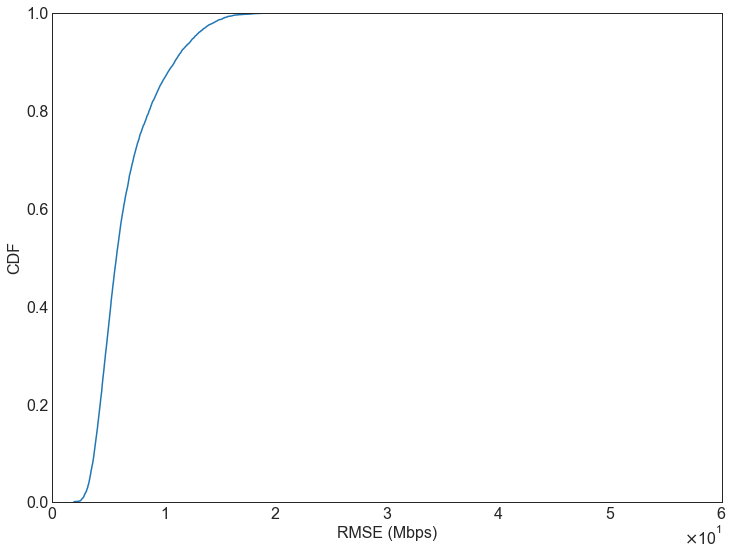

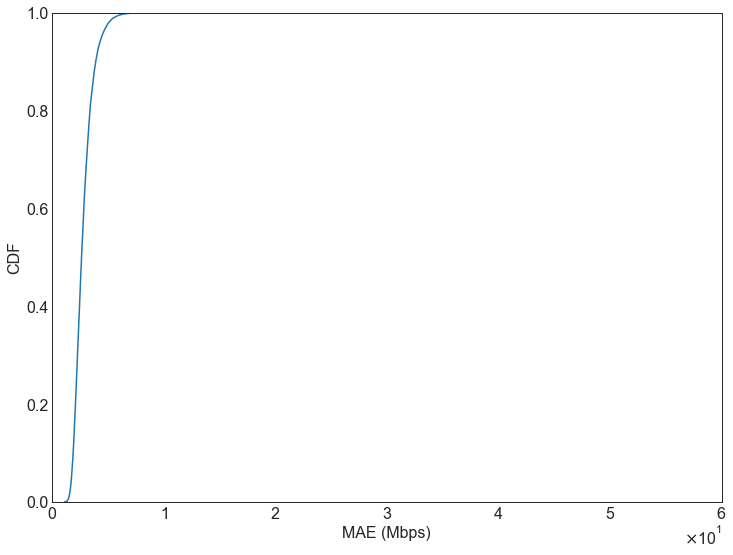

In [123]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)